In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [10]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

def execute_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    logger = make_logger(output_dir, file_level=logging.DEBUG)

    transition_conf = conf.get("transition_conf", {})
    if "model_dir" in transition_conf:
        transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
        lang_path = add_sep(transition_conf["model_dir"]) + lang_name
    lang = Language.load(lang_path, device=conf.get("device"))
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, **transition_conf)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_conf", {}))
    policy_class = class_from_package("policy", conf.get("policy_class"))
    policy = policy_class(**conf.get("policy_conf", {}))

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization
    generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **conf.get("generator_conf", {}))

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)

    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_conf", {}))
    generator.analyze()
    
    return generator, conf

def queue_yaml(*args: str):
    for yaml_path in args:
        execute_yaml(yaml_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Is CUDA available: False
Starting generation...
1- time: 0.00, reward: -0.143992265863037, node: PEPTIDE1{[ac].S.P.P}$$$$
2- time: 0.00, reward: -0.7110982426120188, node: PEPTIDE1{A.A.E.A.A.A.R.K.I.R.Q.A.R.[Sar].L.S.R.V.F.I.L.I}$$$$
3- time: 0.00, reward: -0.6805275501762357, node: PEPTIDE1{[ac].F.Q.S.K.A.N.V.F.V.D.G.Y.F.E.R.L.R.A.G.L.[am]}$$$$
4- time: 0.10, reward: -0.2565856690002727, node: PEPTIDE1{S.A.G.V.A.P.F}$$$$
5- time: 0.10, reward: -0.07265176820402106, node: PEPTIDE1{[Glp].L.P.[am]}$$$$
6- time: 0.10, reward: -0.2151165301252751, node: PEPTIDE1{[Glp].H.K.[am]}$$$$
7- time: 0.14, reward: -0.5808927021824764, node: PEPTIDE1{C.F.Q.W.Q.R.N.M.R.K.V.R}$$$$
8- time: 0.14, reward: -0.8255056606331064, node: PEPTIDE1{C.G.E.L.Q.Q.Q.L.P.Y.Q.A.A.G.N.H.A.A.G.I.L.T.P}$$$$
9- time: 0.24, reward: -0.0315395358501039, node: PEPTIDE1{[ac].A.F.G.E.L.I.Y.[am]}$$$$
10- time: 0.24, reward: -0.674626586886164, node: PEPTIDE1{[ac].F.Q.S.K.G.N.V.F.V.D.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
11- time: 0.24,

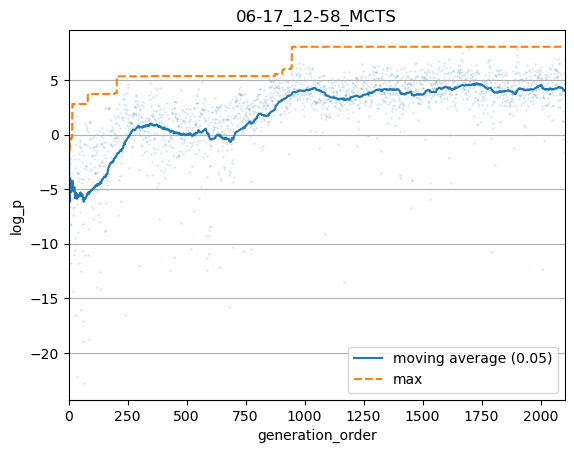

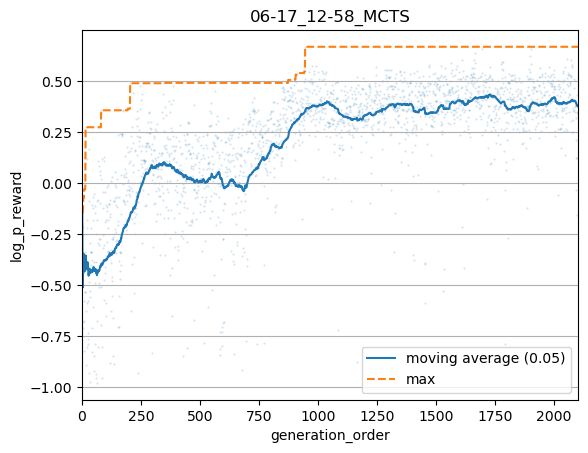

number of generated nodes: 2103
valid rate: 0.7389117512574302
unique rate: 0.7418838591678099
node_per_sec: 35.049053643864355


In [12]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
generator, conf = execute_yaml(c2)
# queue_yaml(c1, c2)

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [14]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
execute_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)